<a href="https://colab.research.google.com/github/ykitaguchi77/GO_AI_project/blob/main/Interference_models_using_external_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Interference using pretrained models**

In [1]:
import torch
from IPython.display import Image, clear_output
import os
import shutil
import glob

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#GDriveをマウント
from google.colab import drive
drive.mount('/content/drive')

Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)
Mounted at /content/drive


In [2]:
dataset_folder_path = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/for_validation"

mobileNet_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training/MobileNetV3_aug2.pth"
YOLOv5_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
# specify the image paths

# 番号順に並べる
# https://dlrecord.hatenablog.com/entry/2020/07/30/230234


import re
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

grav_list = sorted([i for i in glob.glob(f"{dataset_folder_path}/treated_640px/*")], key=natural_keys)
cont_list = sorted([i for i in glob.glob(f"{dataset_folder_path}/control_640px/*")], key=natural_keys)
image_list = grav_list + cont_list
label_list = [1]*len(grav_list) + [0]*len(cont_list)

image_list


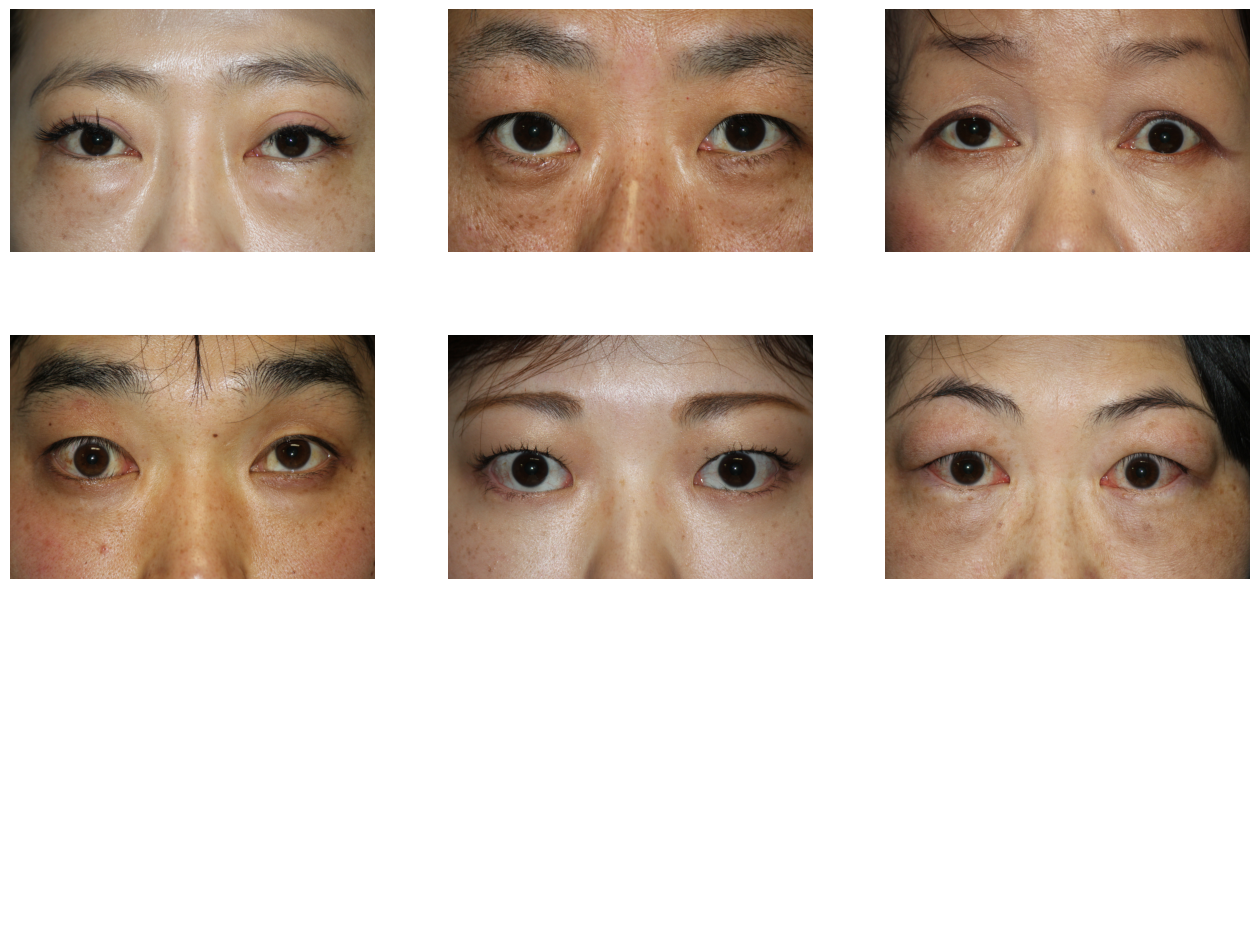

In [4]:
# show sample images
import matplotlib.pyplot as plt
import cv2
import os

root = f"{dataset_folder_path}/treated_640px" #画像があるフォルダ。適宜変えてください
lsdir = os.listdir(root)

imgs = []
for l in lsdir:
    target = os.path.join(root,l)
    img = cv2.imread(target)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #pyplotで表示するために色変換
    imgs.append(img)

shownumber = 6 #画像を並べる数
showaxis = 1

while(showaxis*showaxis < shownumber):
    showaxis += 1

cnt = 0
while(1):
    limit = 6
    if cnt >= limit:
       break
    fig,axs = plt.subplots(showaxis,showaxis, figsize=(16.0, 12.0))
    ar = axs.ravel()
    for i in range(showaxis*showaxis):
        ar[i].axis('off')
        if i < shownumber:
            ar[i].imshow(imgs[cnt])
            cnt += 1
    plt.show()

###**Load model**

In [6]:
##########################
# Load model 
##########################
!pip install --quiet timm
import timm
import torch.nn as nn

model_ft = timm.create_model('mobilenetv3_large_100', pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

#ネットワークの読み込み
model_ft.load_state_dict(torch.load(mobileNet_path))

<All keys matched successfully>

In [7]:
from torchvision import datasets, models, transforms
from PIL import *
import pandas as pd


img_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = img_transforms(image).float()
    image = image.unsqueeze(0) 
    return image.to(device)

def my_round(val, digit=0):
    p = 10 ** digit
    return (val * p * 2 + 1) // 2 / p

def interference(image_list):
    image_tensor = image_loader(path)

    model_ft.to(device)
    model_ft.eval()
    output = model_ft(image_tensor)
    _, pred = torch.max(output, 1) 
    pred = pred[0].to('cpu').detach().numpy().copy().tolist() 

    prob = nn.Softmax(dim=1)(output) #calculate probalility
    prob = prob[0][1].cpu().detach().numpy().copy().tolist() #probalility of being positive
    prob = my_round(prob, 3)

    return pred, prob, image_tensor

In [15]:
# multiple image eval
path_list, pred_list, prob_list = [], [], []
for idx, path in enumerate(image_list, 1):
    pred, prob, _ = interference(path)
    path_list.append(os.path.basename(path)) 
    pred_list.append(pred)
    prob_list.append(prob)
print(label_list)
print(pred_list)
print(prob_list)

df = pd.DataFrame(index=[], columns=[])
df["path"] = path_list
df["label"] = label_list
df["pred"] = pred_list
df["prob"] = prob_list
df.to_csv('/content/gravcont_newPatient_mobileNetv3.csv', header=True, index=False, encoding = "utf-8")

pd.set_option('display.max_rows', 400)
df



[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

,path,label,pred,prob
0,4.JPG,1,1,0.920
1,6.JPG,1,1,0.923
2,16.JPG,1,1,0.647
3,30.JPG,1,1,0.827
4,42.JPG,1,1,0.760
5,43.JPG,1,1,0.936
6,45.JPG,1,1,0.707
7,49.JPG,1,1,0.922
8,63.JPG,1,1,0.991
9,73.JPG,1,1,0.859


In [ ]:
pd.set_option('display.max_rows', None)
df

In [17]:
# single image eval
num = 5
path = image_list[num]
label = label_list[num]
print(f"path: {path}")

pred, prob, tensor = interference(path) 
print(f"label: {label}, pred: {pred}, prob: {prob}")
print(tensor)

path: /content/drive/MyDrive/Deep_learning/Olympia_dataset/for_validation/treated_640px/43.JPG
label: 1, pred: 1, prob: 0.936
tensor([[[[-1.5357, -1.4843, -1.4500,  ..., -1.8782, -1.8782, -1.8439],
          [-1.5699, -1.4329, -1.3987,  ..., -1.8782, -1.8953, -1.8782],
          [-1.5699, -1.4158, -1.3473,  ..., -1.8782, -1.8782, -1.9124],
          ...,
          [-1.2103, -1.1760, -1.1075,  ..., -0.3027, -0.3712, -0.4054],
          [-1.2445, -1.1932, -1.1247,  ..., -0.3198, -0.2856, -0.3712],
          [-1.2617, -1.1932, -1.1075,  ..., -0.3712, -0.3541, -0.4054]],

         [[-1.5280, -1.4580, -1.4580,  ..., -1.8256, -1.8431, -1.8431],
          [-1.5280, -1.4055, -1.3704,  ..., -1.8431, -1.8431, -1.8606],
          [-1.5455, -1.4055, -1.3529,  ..., -1.8431, -1.8606, -1.8782],
          ...,
          [-1.3529, -1.3529, -1.3179,  ..., -0.8978, -0.8978, -0.9328],
          [-1.3704, -1.3529, -1.3179,  ..., -0.9153, -0.8803, -0.9153],
          [-1.3354, -1.3354, -1.3004,  ..., -0.932

#**ROC curve**

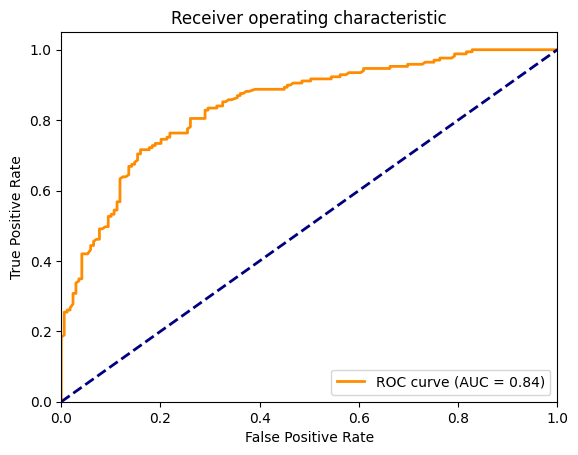

Confusion Matrix:
 [[ 74  95]
 [ 12 157]]
Accuracy: 0.6834319526627219
Sensitivity: 0.9289940828402367
Specificity: 0.4378698224852071
Positive Predictive Value: 0.623015873015873
F1-Score: 0.7458432304038004


In [13]:
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt


# 真陽性率（TPR）、偽陽性率（FPR）、しきい値（thresholds）を計算する
fpr, tpr, thresholds = roc_curve(df['label'], df['prob'])

# AUCスコアを計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


cm = confusion_matrix(df['label'], df['pred'])
accuracy = accuracy_score(df['label'], df['pred'])
sensitivity = recall_score(df['label'], df['pred'])
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
ppv = precision_score(df['label'], df['pred'])
f1 = f1_score(df['label'], df['pred'])

print('Confusion Matrix:\n', cm) # 混同行列
print('Accuracy:', accuracy) # 正解率
print('Sensitivity:', sensitivity) # 感度
print('Specificity:', specificity) # 特異度
print('Positive Predictive Value:', ppv) # 陽性的中率
print('F1-Score:', f1) # F1スコア

#**Output CoreML**

In [ ]:
###########################
# Output as CoreML_example
###########################
import torch.nn as nn
import torch
import torchvision
!pip install --quiet coremltools
import coremltools as ct
import numpy as np
!pip install --quiet timm


# Load a pre-trained version of MobileNetV3

base_model = timm.create_model('mobilenetv3_large_100', pretrained=True)

class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            base_model,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)

# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()

# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
import urllib
label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = class_labels[1:] # remove the first class which is background
assert len(class_labels) == 1000


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale,
                           bias=[red_bias, green_bias, blue_bias])

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input], 
    classifier_config = ct.ClassifierConfig(class_labels), 
    compute_units=ct.ComputeUnit.CPU_ONLY,
)

# Save model
mlmodel.save("MobileNetV3_pytorch.mlmodel")

     |████████████████████████████████| 1.5 MB 6.8 MB/s 


Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '879', of the source model, has been renamed to 'var_879' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1466.69 ops/s]


In [ ]:
###########################
# Output as CoreML 飛ばして下さい
###########################

import torch
import torchvision
import torch.nn as nn
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

image_input = ct.ImageType(name="input_1",
                           shape=example_input.shape,
                           scale=scale,
                           bias=[red_bias, green_bias, blue_bias])

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[image_input], 
    classifier_config = ct.ClassifierConfig(class_labels), 
    compute_units=ct.ComputeUnit.CPU_ONLY,
)


# # Convert to Core ML using the Unified Conversion API
# mlmodel = ct.convert(
#     traced_model,
#     inputs=[ct.ImageType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
#     classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
# )

# Save model
mlmodel.save("/content/gravcont_mobilenetv3.mlmodel")


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1744.69 ops/s]


In [ ]:
################################
### Output as CoreML (Tensor type) ###
################################
import torch
import torchvision
import torch.nn as nn
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]

# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.TensorType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
    classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
)

# Save model
mlmodel.save("/content/gravcont_mobilenetv3.mlmodel")

Running MIL Common passes:   0%|          | 0/38 [00:00<?, ? passes/s]/usr/local/lib/python3.7/dist-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '879', of the source model, has been renamed to 'var_879' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1717.72 ops/s]


#**Interference on CoreML model**

In [ ]:
# This script can be used in Mac only

##https://gist.github.com/ozgurshn/85cf74558d82c831827e12f015f752a1
##https://github.com/apple/coremltools/blob/master/examples/APIExamples.md
import coremltools
import numpy as np
import PIL.Image

# load a model whose input type is "Image"
model = coremltools.models.MLModel('/content/gravcont_mobilenetv3.mlmodel')

Height = 224  # use the correct input image height
Width = 224  # use the correct input image width


# Scenario 1: load an image from disk
def load_image(path, resize_to=None):
    # resize_to: (Width, Height)
    img = PIL.Image.open(path)
    if resize_to is not None:
        img = img.resize(resize_to, PIL.Image.ANTIALIAS)
    img_np = np.array(img).astype(np.float32)
    return img_np, img


# load the image and resize using PIL utilities
_, img = load_image('/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_newPatient_250px/スライド1.jpeg', resize_to=(Width, Height))
out_dict = model.predict({'image': img})

# Scenario 2: load an image from a numpy array
shape = (Height, Width, 3)  # height x width x RGB
data = np.zeros(shape, dtype=np.uint8)
# manipulate numpy data
pil_img = PIL.Image.fromarray(data)
out_dict = model.predict({'image': pil_img})

Exception: ignored

##**Interference without Mac**

In [ ]:
#https://tvm.apache.org/docs/how_to/compile_models/from_coreml.html
!pip install --quiet apache-tvm
!pip install --quiet coremltools
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata
import coremltools as cm
import numpy as np
from PIL import Image

     |████████████████████████████████| 42.8 MB 1.2 MB/s 


###**Load the model**

In [ ]:
model_url = "https://docs-assets.developer.apple.com/coreml/models/MobileNet.mlmodel"
model_file = "mobilenet.mlmodel"
model_path = download_testdata(model_url, model_file, module="coreml")
# Now you have mobilenet.mlmodel on disk
mlmodel = cm.models.MLModel(model_path)

###**Load the test image**

In [ ]:
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))
# Mobilenet.mlmodel's input is BGR format
img_bgr = np.array(img)[:, :, ::-1]
x = np.transpose(img_bgr, (2, 0, 1))[np.newaxis, :]

###**Compile model on relay**

In [ ]:
target = "llvm"
shape_dict = {"image": x.shape}

# Parse CoreML model and convert into Relay computation graph
mod, params = relay.frontend.from_coreml(mlmodel, shape_dict)

with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target, params=params)

/usr/local/lib/python3.7/dist-packages/tvm/driver/build_module.py:268: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  "target_host parameter is going to be deprecated. "


In [ ]:
#Execute on TVM (これはサンプルの通り)
from tvm.contrib import graph_executor

dev = tvm.cpu(0)
dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# set inputs
m.set_input("image", tvm.nd.array(x.astype(dtype)))
# execute
m.run()
# get outputs
tvm_output = m.get_output(0)
top1 = np.argmax(tvm_output.numpy()[0])

###**Look up system name**

In [ ]:
synset_url = "".join(
    [
        "https://gist.githubusercontent.com/zhreshold/",
        "4d0b62f3d01426887599d4f7ede23ee5/raw/",
        "596b27d23537e5a1b5751d2b0481ef172f58b539/",
        "imagenet1000_clsid_to_human.txt",
    ]
)
synset_name = "imagenet1000_clsid_to_human.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synset = eval(f.read())
# You should see the following result: Top-1 id 282 class name tiger cat
print("Top-1 id", top1, "class name", synset[top1])

Top-1 id 282 class name tiger cat
